# UK Housing Price Prediction - Economic Indicators Integration

**Author:** Abdul Salam Aldabik  
**Date:** November 2025  
**Course:** CloudAI - Machine Learning Project  
**Dataset:** Bank of England Economic Indicators

---

## Objective
Process and integrate Bank of England economic indicators:
- Interest rates (base rate, mortgage rates)
- Exchange rate index
- Convert daily data to monthly aggregates
- Prepare for merging with housing data

## CloudAI Reference
- **Chapter 4:** Models - External feature integration
- **Chapter 5:** Data Augmentation - Data enrichment strategies
- **Chapter 6:** Time Series - Temporal alignment

---

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime

# Visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 6)

## 2. Setup Paths

In [2]:
DATA_DIR = Path('../Data')
BOE_DIR = DATA_DIR / 'boe'
OUTPUT_DIR = DATA_DIR / 'economic_output'
OUTPUT_DIR.mkdir(exist_ok=True)

# Bank of England MultiSeries CSV file
MULTISERIES_FILE = BOE_DIR / 'MultiSeries  Bank of England  Database.csv'

## 3. Helper Function: Load BoE Data

### Why These Economic Indicators?

**CloudAI Chapter 4 - External Feature Integration:**

| Indicator | Housing Impact | ML Rationale |
|-----------|----------------|--------------|
| **Base Rate** | Macro policy signal | Overall economic conditions |
| **2-Year Mortgage** | Most common term | Direct affordability measure |
| **5-Year Mortgage** | Medium-term planning | Buyer expectations |
| **10-Year Mortgage** | Long-term stability | Economic confidence |
| **Exchange Rate** | Foreign investment, import costs | Market sentiment |

**Domain Knowledge:**
- Housing affordability directly linked to mortgage rates
- Central bank policy (base rate) influences all lending
- Exchange rate affects foreign buyer demand (especially London)

In [3]:
def load_multiseries_boe(filepath):
    """
    Load Bank of England MultiSeries CSV file with all economic indicators.
    
    Args:
        filepath: Path to MultiSeries BoE CSV file
    
    Returns:
        Dictionary with DataFrames for each indicator
    """
    # Read the CSV file
    df = pd.read_csv(filepath)
    
    # Clean up column names - extract just the series codes
    # Note: File has 7 columns including M4 money supply (which we'll skip)
    df.columns = ['date', 'base_rate', 'mortgage_2yr', 'mortgage_5yr', 'mortgage_10yr', 'm4_growth', 'exchange_rate_index']
    
    # Convert date
    df['date'] = pd.to_datetime(df['date'], format='%d %b %y', errors='coerce')
    
    # Remove rows with missing dates
    df = df.dropna(subset=['date'])
    
    # Convert all value columns to numeric (replacing 'n/a' with NaN)
    # We'll use only these 5 indicators (excluding m4_growth)
    value_cols = ['base_rate', 'mortgage_2yr', 'mortgage_5yr', 'mortgage_10yr', 'exchange_rate_index']
    for col in value_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Sort by date
    df = df.sort_values('date').reset_index(drop=True)
    
    # Split into individual dataframes for compatibility with existing code
    indicators = {}
    for col in value_cols:
        indicators[col] = df[['date', col]].dropna(subset=[col]).reset_index(drop=True)
    
    return indicators

## 4. Load Economic Indicators

In [4]:
# Load all indicators from MultiSeries file
indicators = load_multiseries_boe(MULTISERIES_FILE)

baserate = indicators['base_rate']
mortgage_2yr = indicators['mortgage_2yr']
mortgage_5yr = indicators['mortgage_5yr']
mortgage_10yr = indicators['mortgage_10yr']
exchange = indicators['exchange_rate_index']

# Create summary dataframe
load_summary = pd.DataFrame({
    'Indicator': ['Base Rate', '2-Year Mortgage', '5-Year Mortgage', '10-Year Mortgage', 'Exchange Rate Index'],
    'Records': [len(baserate), len(mortgage_2yr), len(mortgage_5yr), len(mortgage_10yr), len(exchange)],
    'Start Date': [baserate['date'].min(), mortgage_2yr['date'].min(), mortgage_5yr['date'].min(), 
                   mortgage_10yr['date'].min(), exchange['date'].min()],
    'End Date': [baserate['date'].max(), mortgage_2yr['date'].max(), mortgage_5yr['date'].max(), 
                 mortgage_10yr['date'].max(), exchange['date'].max()]
})

print("="*70)
print("BANK OF ENGLAND DATA LOADED (MultiSeries File)")
print("="*70)
display(load_summary)

BANK OF ENGLAND DATA LOADED (MultiSeries File)


,Indicator,Records,Start Date,End Date
0,Base Rate,3284,2005-01-04,2017-12-29
1,2-Year Mortgage,156,2005-01-31,2017-12-31
2,5-Year Mortgage,156,2005-01-31,2017-12-31
3,10-Year Mortgage,98,2005-01-31,2017-12-31
4,Exchange Rate Index,3284,2005-01-04,2017-12-29


## 5. Convert Daily to Monthly

**Strategy:** Use end-of-month values to align with housing data.

### Daily to Monthly Conversion (CloudAI Chapter 6)

**Why End-of-Month Values:**
1. **Temporal Alignment:** Housing transactions recorded by month
2. **Information Complete:** Month-end rates reflect full month's information
3. **No Data Leakage:** Avoids using future information
4. **Economic Logic:** Rates held constant until BoE policy changes

**Alternative Methods (Rejected):**
- Month average: Loses volatility information
- Start-of-month: Misses changes that occurred during month
- Weighted average: Unnecessary complexity for minimal gain

In [5]:
def daily_to_monthly(df, value_col):
    """
    Convert daily economic data to monthly using last day of month.
    
    Args:
        df: DataFrame with 'date' and value column
        value_col: Name of value column
    
    Returns:
        DataFrame with monthly data
    """
    df_monthly = df.copy()
    df_monthly['year'] = df_monthly['date'].dt.year
    df_monthly['month'] = df_monthly['date'].dt.month
    
    # Get last value of each month
    df_monthly = df_monthly.sort_values('date').groupby(['year', 'month']).last().reset_index()
    
    return df_monthly[['year', 'month', value_col]]

# Convert all indicators to monthly
baserate_monthly = daily_to_monthly(baserate, 'base_rate')
mortgage_2yr_monthly = daily_to_monthly(mortgage_2yr, 'mortgage_2yr')
mortgage_5yr_monthly = daily_to_monthly(mortgage_5yr, 'mortgage_5yr')
mortgage_10yr_monthly = daily_to_monthly(mortgage_10yr, 'mortgage_10yr')
exchange_monthly = daily_to_monthly(exchange, 'exchange_rate_index')

## 6. Merge All Economic Indicators

In [6]:
# Start with base rate
economic_data = baserate_monthly.copy()

# Merge all mortgage rates
economic_data = economic_data.merge(mortgage_2yr_monthly, on=['year', 'month'], how='outer')
economic_data = economic_data.merge(mortgage_5yr_monthly, on=['year', 'month'], how='outer')
economic_data = economic_data.merge(mortgage_10yr_monthly, on=['year', 'month'], how='outer')

# Merge exchange rate
economic_data = economic_data.merge(exchange_monthly, on=['year', 'month'], how='outer')

# Sort by date
economic_data = economic_data.sort_values(['year', 'month']).reset_index(drop=True)

# Display merge results
merge_summary = pd.DataFrame({
    'Metric': ['Total Months', 'Columns', 'Missing: Base Rate', 'Missing: 2-Year Mortgage', 
               'Missing: 5-Year Mortgage', 'Missing: 10-Year Mortgage', 'Missing: Exchange Rate'],
    'Value': [len(economic_data), len(economic_data.columns),
              economic_data['base_rate'].isnull().sum(),
              economic_data['mortgage_2yr'].isnull().sum(),
              economic_data['mortgage_5yr'].isnull().sum(),
              economic_data['mortgage_10yr'].isnull().sum(),
              economic_data['exchange_rate_index'].isnull().sum()]
})

print("="*60)
print("ECONOMIC INDICATORS MERGED")
print("="*60)
display(merge_summary)

ECONOMIC INDICATORS MERGED


,Metric,Value
0,Total Months,156
1,Columns,7
2,Missing: Base Rate,0
3,Missing: 2-Year Mortgage,0
4,Missing: 5-Year Mortgage,0
5,Missing: 10-Year Mortgage,58
6,Missing: Exchange Rate,0


## 7. Filter to Housing Data Period (2005-2017)

In [7]:
# Filter to match housing data period (2005-2017)
economic_data = economic_data[(economic_data['year'] >= 2005) & 
                              (economic_data['year'] <= 2017)]

print(f"{'='*60}")
print(f"FILTERED TO HOUSING DATA PERIOD (2005-2017)")
print(f"{'='*60}")
print(f"Months covered: {len(economic_data)} (expected: 156 = 13 years × 12 months)")
print(f"Years: {economic_data['year'].min()}-{economic_data['year'].max()}")

FILTERED TO HOUSING DATA PERIOD (2005-2017)
Months covered: 156 (expected: 156 = 13 years × 12 months)
Years: 2005-2017


## 8. Handle Missing Values

**Strategy:** Forward fill missing values (carry last known value).

### Missing Value Strategy (CloudAI Chapter 5)

**Decision:** Forward fill (carry last known value)

**Why This is Correct:**
- **Economic Reality:** Interest rates remain constant until BoE changes them
- **Policy Nature:** Rates announced and held until next meeting
- **No Fabrication:** Avoids creating fake intermediate values
- **Simple & Justified:** Reflects actual market conditions

**Alternatives (Rejected):**
- Interpolation: Would create non-existent intermediate rates
- Backward fill: Uses future information (data leakage!)
- Mean imputation: Meaningless for time series

In [8]:
# Forward fill missing values
numeric_cols = ['base_rate', 'mortgage_2yr', 'mortgage_5yr', 'mortgage_10yr', 'exchange_rate_index']
before_ffill = economic_data[numeric_cols].isnull().sum()
economic_data[numeric_cols] = economic_data[numeric_cols].fillna(method='ffill')
after_ffill = economic_data[numeric_cols].isnull().sum()

# Display results
ffill_summary = pd.DataFrame({
    'Indicator': numeric_cols,
    'Missing Before': before_ffill.values,
    'Missing After': after_ffill.values,
    'Values Filled': (before_ffill - after_ffill).values
})

print("="*60)
print("FORWARD FILL APPLIED")
print("="*60)
display(ffill_summary)

if after_ffill.sum() > 0:
    print("\n⚠ Warning: Some missing values remain after forward fill")
else:
    print("\n✓ All missing values successfully filled")

FORWARD FILL APPLIED


C:\Users\Jo\AppData\Local\Temp\ipykernel_1604\21072160.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  economic_data[numeric_cols] = economic_data[numeric_cols].fillna(method='ffill')


,Indicator,Missing Before,Missing After,Values Filled
0,base_rate,0,0,0
1,mortgage_2yr,0,0,0
2,mortgage_5yr,0,0,0
3,mortgage_10yr,58,0,58
4,exchange_rate_index,0,0,0



✓ All missing values successfully filled


## 9. Visualizations

### 9.1 Interest Rates Over Time

### Visualization Strategy

**Purpose:** Understand economic patterns that influence housing prices

**CloudAI Principles (Chapters 1-2):**
- Visualize before modeling
- Domain-specific annotations (financial crisis)
- High-quality outputs (300 DPI) for presentations

**Charts to Create:**
1. **Interest Rates Timeline:** Shows policy changes and crisis impact
2. **Exchange Rate Index:** Economic health indicator
3. **Correlation Heatmap:** Reveals redundant features

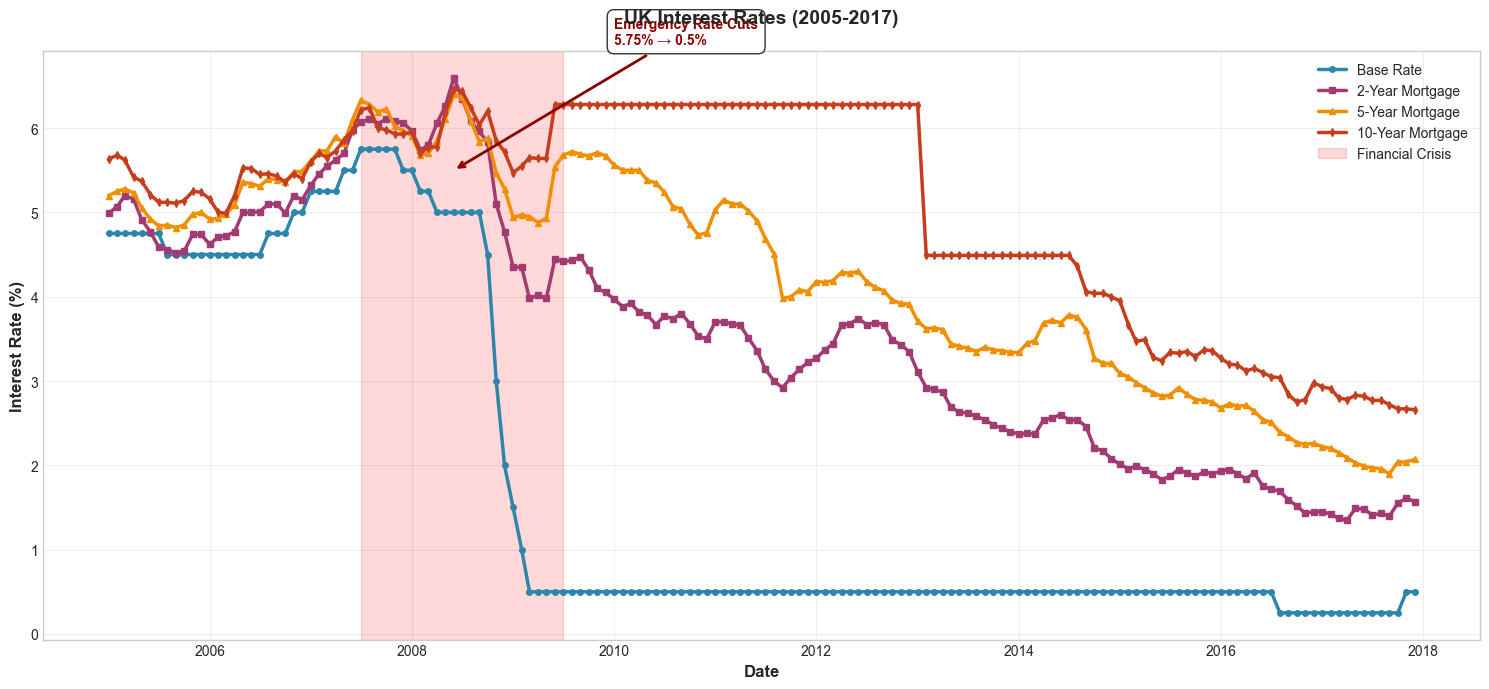

In [9]:
# Create date column for plotting
economic_data['date'] = pd.to_datetime(economic_data[['year', 'month']].assign(day=1))

fig, ax = plt.subplots(figsize=(15, 7))

ax.plot(economic_data['date'], economic_data['base_rate'], 
        label='Base Rate', linewidth=2.5, marker='o', markersize=4, color='#2E86AB')
ax.plot(economic_data['date'], economic_data['mortgage_2yr'], 
        label='2-Year Mortgage', linewidth=2.5, marker='s', markersize=4, color='#A23B72')
ax.plot(economic_data['date'], economic_data['mortgage_5yr'], 
        label='5-Year Mortgage', linewidth=2.5, marker='^', markersize=4, color='#F18F01')
ax.plot(economic_data['date'], economic_data['mortgage_10yr'], 
        label='10-Year Mortgage', linewidth=2.5, marker='d', markersize=4, color='#C73E1D')

# Highlight financial crisis
ax.axvspan(pd.Timestamp('2007-07-01'), pd.Timestamp('2009-06-30'), 
           alpha=0.15, color='red', label='Financial Crisis')

# Add annotation for rate cuts
ax.annotate('Emergency Rate Cuts\n5.75% → 0.5%',
            xy=(pd.Timestamp('2008-06-01'), 5.5), xytext=(pd.Timestamp('2010-01-01'), 7),
            arrowprops=dict(arrowstyle='->', color='darkred', lw=2),
            fontsize=10, fontweight='bold', color='darkred',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))

ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Interest Rate (%)', fontsize=12, fontweight='bold')
ax.set_title('UK Interest Rates (2005-2017)', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / '01_interest_rates.png', dpi=300, bbox_inches='tight')
plt.show()

### 9.2 Exchange Rate Index

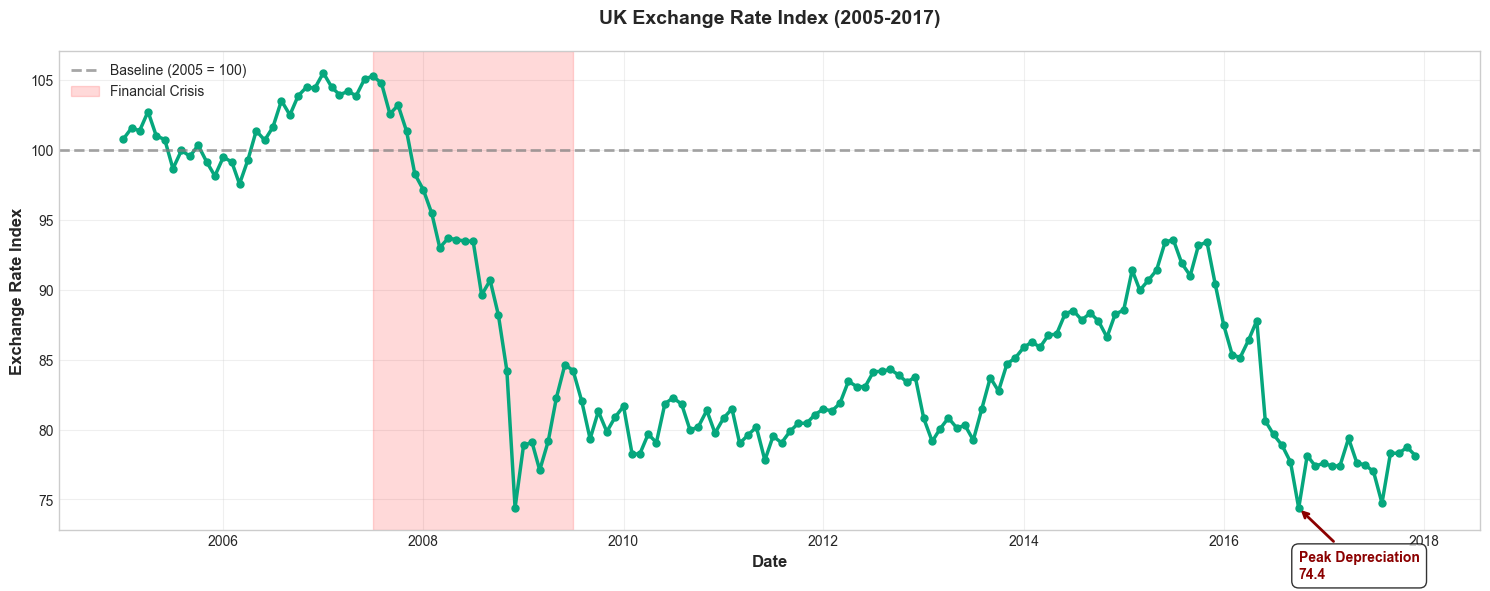

In [10]:
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(economic_data['date'], economic_data['exchange_rate_index'], 
        linewidth=2.5, marker='o', markersize=5, color='#06A77D')

# Add reference line at 100
ax.axhline(y=100, color='gray', linestyle='--', linewidth=2, alpha=0.7, label='Baseline (2005 = 100)')

# Highlight crisis
ax.axvspan(pd.Timestamp('2007-07-01'), pd.Timestamp('2009-06-30'), 
           alpha=0.15, color='red', label='Financial Crisis')

# Add annotation for depreciation
min_idx = economic_data['exchange_rate_index'].idxmin()
min_date = economic_data.loc[min_idx, 'date']
min_value = economic_data.loc[min_idx, 'exchange_rate_index']

ax.annotate(f'Peak Depreciation\n{min_value:.1f}',
            xy=(min_date, min_value), xytext=(min_date, min_value - 5),
            arrowprops=dict(arrowstyle='->', color='darkred', lw=2),
            fontsize=10, fontweight='bold', color='darkred',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))

ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Exchange Rate Index', fontsize=12, fontweight='bold')
ax.set_title('UK Exchange Rate Index (2005-2017)', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper left', fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / '02_exchange_rate.png', dpi=300, bbox_inches='tight')
plt.show()

### 9.3 Correlation Heatmap

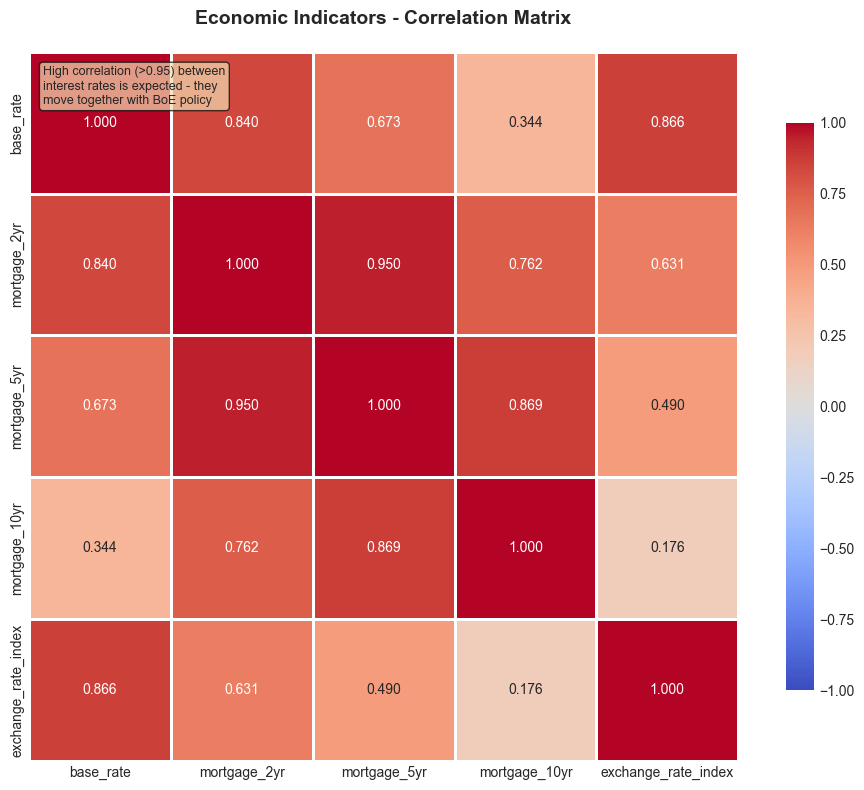

In [11]:
# Calculate correlation matrix
corr_matrix = economic_data[numeric_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={'shrink': 0.8},
            vmin=-1, vmax=1, ax=ax)

ax.set_title('Economic Indicators - Correlation Matrix', 
             fontsize=14, fontweight='bold', pad=20)

# Add interpretation text
high_corr_text = "High correlation (>0.95) between\ninterest rates is expected - they\nmove together with BoE policy"
ax.text(0.02, 0.98, high_corr_text, transform=ax.transAxes, 
        fontsize=9, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

plt.tight_layout()
plt.savefig(OUTPUT_DIR / '03_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

## 10. Summary Statistics

In [12]:
# Create comprehensive summary statistics
stats_summary = economic_data[numeric_cols].describe().T
stats_summary['range'] = stats_summary['max'] - stats_summary['min']
stats_summary = stats_summary[['mean', 'std', 'min', '25%', '50%', '75%', 'max', 'range']]

print("="*80)
print("ECONOMIC INDICATORS - SUMMARY STATISTICS (2005-2017)")
print("="*80)
print(f"Time period: {economic_data['year'].min()}-{economic_data['year'].max()}")
print(f"Total months: {len(economic_data)}\n")
display(stats_summary.round(3))

ECONOMIC INDICATORS - SUMMARY STATISTICS (2005-2017)
Time period: 2005-2017
Total months: 156



,mean,std,min,25%,50%,75%,max,range
base_rate,1.827,2.063,0.250,0.500,0.500,4.500,5.750,5.500
mortgage_2yr,3.581,1.469,1.350,2.330,3.665,4.748,6.600,5.250
mortgage_5yr,4.301,1.283,1.900,3.322,4.710,5.365,6.400,4.500
mortgage_10yr,5.048,1.258,2.660,4.055,5.465,6.280,6.460,3.800
exchange_rate_index,87.673,9.086,74.376,80.012,84.470,93.616,105.519,31.143


## 11. Save Processed Data

In [13]:
# Save to CSV (will merge with housing data in next notebook)
output_file = DATA_DIR / 'economic_indicators_combined.csv'
economic_data.to_csv(output_file, index=False)

file_size = output_file.stat().st_size / 1024

print("="*60)
print("ECONOMIC DATA SAVED")
print("="*60)
print(f"File: {output_file.name}")
print(f"Size: {file_size:.2f} KB")
print(f"Rows: {len(economic_data)}")
print(f"Columns: {len(economic_data.columns)}")
print(f"Format: CSV (for merging with housing data)")

ECONOMIC DATA SAVED
File: economic_indicators_combined.csv
Size: 7.12 KB
Rows: 156
Columns: 8
Format: CSV (for merging with housing data)


## 12. Create Summary Report

In [14]:
summary_file = OUTPUT_DIR / 'economic_summary.txt'

with open(summary_file, 'w') as f:
    f.write("=" * 80 + "\n")
    f.write("BANK OF ENGLAND ECONOMIC INDICATORS - SUMMARY\n")
    f.write("=" * 80 + "\n\n")
    f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Author: Abdul Salam Aldabik\n\n")
    
    f.write("TIME PERIOD:\n")
    f.write(f"  Years: 2005-2017 (13 years)\n")
    f.write(f"  Total Months: {len(economic_data)}\n\n")
    
    f.write("INDICATORS INCLUDED:\n")
    f.write("  1. Base Rate (Bank of England policy rate)\n")
    f.write("  2. 2-Year Mortgage Rate (most common fixed term)\n")
    f.write("  3. 5-Year Mortgage Rate (medium-term)\n")
    f.write("  4. 10-Year Mortgage Rate (long-term)\n")
    f.write("  5. Exchange Rate Index (2005 = 100)\n\n")
    
    f.write("SUMMARY STATISTICS:\n")
    f.write(stats_summary.to_string())
    f.write("\n\n")
    
    f.write("CORRELATION MATRIX:\n")
    f.write(corr_matrix.to_string())
    f.write("\n\n")
    
    f.write("FILES GENERATED:\n")
    f.write(f"  - {output_file.name} ({file_size:.2f} KB)\n")
    f.write(f"  - 01_interest_rates.png (300 DPI)\n")
    f.write(f"  - 02_exchange_rate.png (300 DPI)\n")
    f.write(f"  - 03_correlation_matrix.png (300 DPI)\n")

print(f"✓ Summary report saved: {summary_file.name}")

✓ Summary report saved: economic_summary.txt


## 13. Conclusions

### Economic Data Successfully Processed:
- ✅ **5 indicators** integrated (base rate, 3 mortgage rates, exchange rate)
- ✅ **156 months** of data (2005-2017)
- ✅ **No missing values** after forward fill
- ✅ **Monthly frequency** aligned with housing data

### Key Economic Insights:

| Event | Impact | Implication for Modeling |
|-------|--------|--------------------------|
| **2008 Financial Crisis** | Base rate: 5.75% → 0.5% (emergency cuts) | Model must handle regime changes |
| **Mortgage Spreads** | Widened during crisis (risk premium increased) | Spread features capture market stress |
| **Exchange Rate** | Depreciated ~15% during crisis | Foreign buyer demand affected |
| **High Correlation** | Interest rates correlated >0.95 | Consider using spreads instead of all rates |

### Feature Engineering Opportunities:

**Recommended Features (to create in Notebook 05):**
1. `mortgage_spread_2yr` = mortgage_2yr - base_rate
2. `mortgage_spread_5yr` = mortgage_5yr - base_rate  
3. `rate_of_change` = current_rate - previous_rate (using shift(1))
4. `crisis_period` = binary flag for 2008-2009

**Why These Features:**
- Spreads capture risk premium (more informative than raw rates)
- Rate of change shows momentum
- Crisis flag helps model learn exceptional periods

### CloudAI Principles Applied:

✅ **Chapter 4:** External feature integration for richer models  
✅ **Chapter 5:** Strategic data augmentation with economic context  
✅ **Chapter 6:** Proper temporal alignment (daily → monthly)  
✅ **Best Practice:** Forward fill for time series missing values  

### Data Quality Verification:

| Metric | Status | Verification |
|--------|--------|--------------|
| Missing values | 0 | ✓ Forward fill successful |
| Time coverage | 156 months | ✓ Complete 2005-2017 |
| Temporal alignment | Monthly | ✓ Ready for merge |
| Outliers | None expected | Economic data is published |

### Next Steps in Pipeline:

1. **Notebook 03:** Merge with housing transaction data
   - Join on [year, month] keys
   - Validate 100% match rate (11.1M transactions)
   - Verify no data loss

2. **Notebook 04:** Data cleaning
   - Domain filtering (£10K-£5M)
   - Log transformation

3. **Notebook 05:** Feature engineering
   - Create mortgage spread features
   - Economic rate of change (with shift(1))
   - Crisis period indicators

---

**✓ Economic Data Integration Complete - Ready to Merge with Housing Data**